# Topological signatures of text embedding models

### Data processing

In [1]:
import pandas as pd
import numpy as np
from config.metrics import SIGNATURE_COLUMNS
from utils.general import (aggregate_results, forward_fill_sample_size, 
                           merge_with_model_details, add_transformed_columns)
%load_ext autoreload

directory = "metric_results"
filename = "metrics_corpus"
filetype = ".csv"

# Load data
df = aggregate_results(directory, filename, filetype)

# Default seed for unknown runs
df["seed"] = df["seed"].fillna(1234)

# Map name
df["dataset"] = df["dataset"].str.replace("CQADupstackEnglishRetrieval", "DupstackEnglish")

# Get largest sample experiment
df = forward_fill_sample_size(df, group_cols=["model", "dataset", "seed"])
print(df.seed.value_counts())

# Fill nans 
nan_vals = df[SIGNATURE_COLUMNS].isna().sum()
print("Nans: \n", nan_vals[nan_vals > 0])
df[SIGNATURE_COLUMNS] = df[SIGNATURE_COLUMNS].fillna(0)

# Merge with model metadata
df = merge_with_model_details(df, "config/model_details.yaml")
assert df.architecture.isna().sum() == 0

# Add transformed columns e.g. normalization
cols_to_transform = ["mag_area", "twonn_dim", "ph_dim_euclidean", 
                     "main_score", "recall_at_20", "iso_score", 
                     "mag_dim", "recall_at_100", "recall_at_5"]
add_transformed_columns(df, cols_to_transform)

# Map model size
df["size"] = pd.cut(df["model_size"], bins=[-np.inf, 0.5, 3, np.inf], labels=["small", "medium", "large"])
print(df["size"].value_counts())
print(df.shape)
df.head()

2026-01-22 06:51:50.015018: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769061112.004347  160986 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769061112.582017  160986 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769061116.928495  160986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769061116.928537  160986 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769061116.928539  160986 computation_placer.cc:177] computation placer alr

Loaded dataframe with shape:  (9078, 63)
Forward filled sample sizes. New shape:  (882, 63)
seed
123.0     294
1234.0    294
2025.0    294
Name: count, dtype: int64
Nans: 
 iso_score    24
dtype: int64
size
small     495
large     255
medium    132
Name: count, dtype: int64
(882, 96)


,model,dataset,seed,uniformity,elapsed_time_uniformity,euler_characteristic,elapsed_time_euler_characteristic,effective_rank,elapsed_time_effective_rank,avg_pair_sim_euclidean,...,recall_at_20_normalized,log_iso_score,iso_score_normalized,log_mag_dim,mag_dim_normalized,log_recall_at_100,recall_at_100_normalized,log_recall_at_5,recall_at_5_normalized,size
0,Alibaba-NLP/gte-Qwen2-1.5B-instruct,ArguAna,123.0,-2.835543,15.537313,-1211.0,47.183821,932.163025,2.662876,0.454974,...,1.083393,-2.589543,-0.640342,1.664531,0.703677,-0.004279,0.690986,-0.180336,1.023577,medium
1,Alibaba-NLP/gte-Qwen2-1.5B-instruct,ArguAna,1234.0,-2.835543,20.655431,-1382.0,45.017129,932.163025,2.492936,0.454974,...,1.083393,-2.589542,-0.640340,1.665065,0.714450,-0.004279,0.690986,-0.180336,1.023577,medium
2,Alibaba-NLP/gte-Qwen2-1.5B-instruct,ArguAna,2025.0,-2.835543,18.030930,-1353.0,66.512056,932.163025,3.255336,0.454974,...,1.083393,-2.589543,-0.640342,1.664538,0.703817,-0.004279,0.690986,-0.180336,1.023577,medium
3,Alibaba-NLP/gte-Qwen2-1.5B-instruct,ClimateFEVER,123.0,-2.801040,96.622768,-4290.0,46.458248,1013.957764,26.575716,0.453690,...,1.473478,-2.948281,-1.219975,1.620539,-0.885438,-0.336788,1.356308,-0.960034,1.583320,medium
4,Alibaba-NLP/gte-Qwen2-1.5B-instruct,ClimateFEVER,1234.0,-2.798660,152.545961,-4251.0,45.289764,1013.692871,29.351171,0.453904,...,1.473478,-2.946307,-1.218954,1.619599,-0.900644,-0.336788,1.356308,-0.960034,1.583320,medium


#### Check data completeness
For some of the Qwen 8B runs we ran out of memory while processing metrics on larger datasets. 

In [3]:
results = []

df_seed = df[df.seed == 2025] # 1234, 123, 2025
for d in df_seed.dataset.unique():
    dataset_results = []
    for m in df_seed.model.unique():
        subset = df_seed[(df_seed.dataset == d) & (df_seed.model == m)]
        is_available = subset.shape[0] > 0
        dataset_results.append(is_available)
    results.append(dataset_results)


def highlight_max(s):
    is_max = s == False
    return ['background-color: red' if v else '' for v in is_max]

pd.DataFrame(np.array(results), columns=df_seed.model.unique(), index=df_seed.dataset.unique()).style.apply(highlight_max, axis=1)

,Alibaba-NLP/gte-Qwen2-1.5B-instruct,Alibaba-NLP/gte-Qwen2-7B-instruct,BAAI/bge-base-en-v1.5,BAAI/bge-large-en-v1.5,BAAI/bge-small-en-v1.5,Qwen/Qwen3-Embedding-0.6B,Qwen/Qwen3-Embedding-4B,Qwen/Qwen3-Embedding-8B,Salesforce/SFR-Embedding-Mistral,Snowflake/snowflake-arctic-embed-m-v1.5,apollo/openai-text-embedding-3-large,apollo/openai-text-embedding-3-small,google/gemini-embedding-001,intfloat/e5-mistral-7b-instruct,intfloat/multilingual-e5-large-instruct,llmrails/ember-v1,mixedbread-ai/mxbai-embed-large-v1,mixedbread-ai/mxbai-embed-xsmall-v1,sentence-transformers/all-MiniLM-L6-v2,sentence-transformers/gtr-t5-base,sentence-transformers/gtr-t5-large,sentence-transformers/gtr-t5-xxl,sentence-transformers/msmarco-distilbert-base-tas-b,sentence-transformers/msmarco-roberta-base-ance-firstp,thenlper/gte-base,thenlper/gte-large,thenlper/gte-small
ArguAna,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
ClimateFEVER,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
DupstackEnglish,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
FiQA2018,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
MSMARCO,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
NFCorpus,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
QuoraRetrieval,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
SCIDOCS,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
SciFact,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
TRECCOVID,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


### Correlation analysis

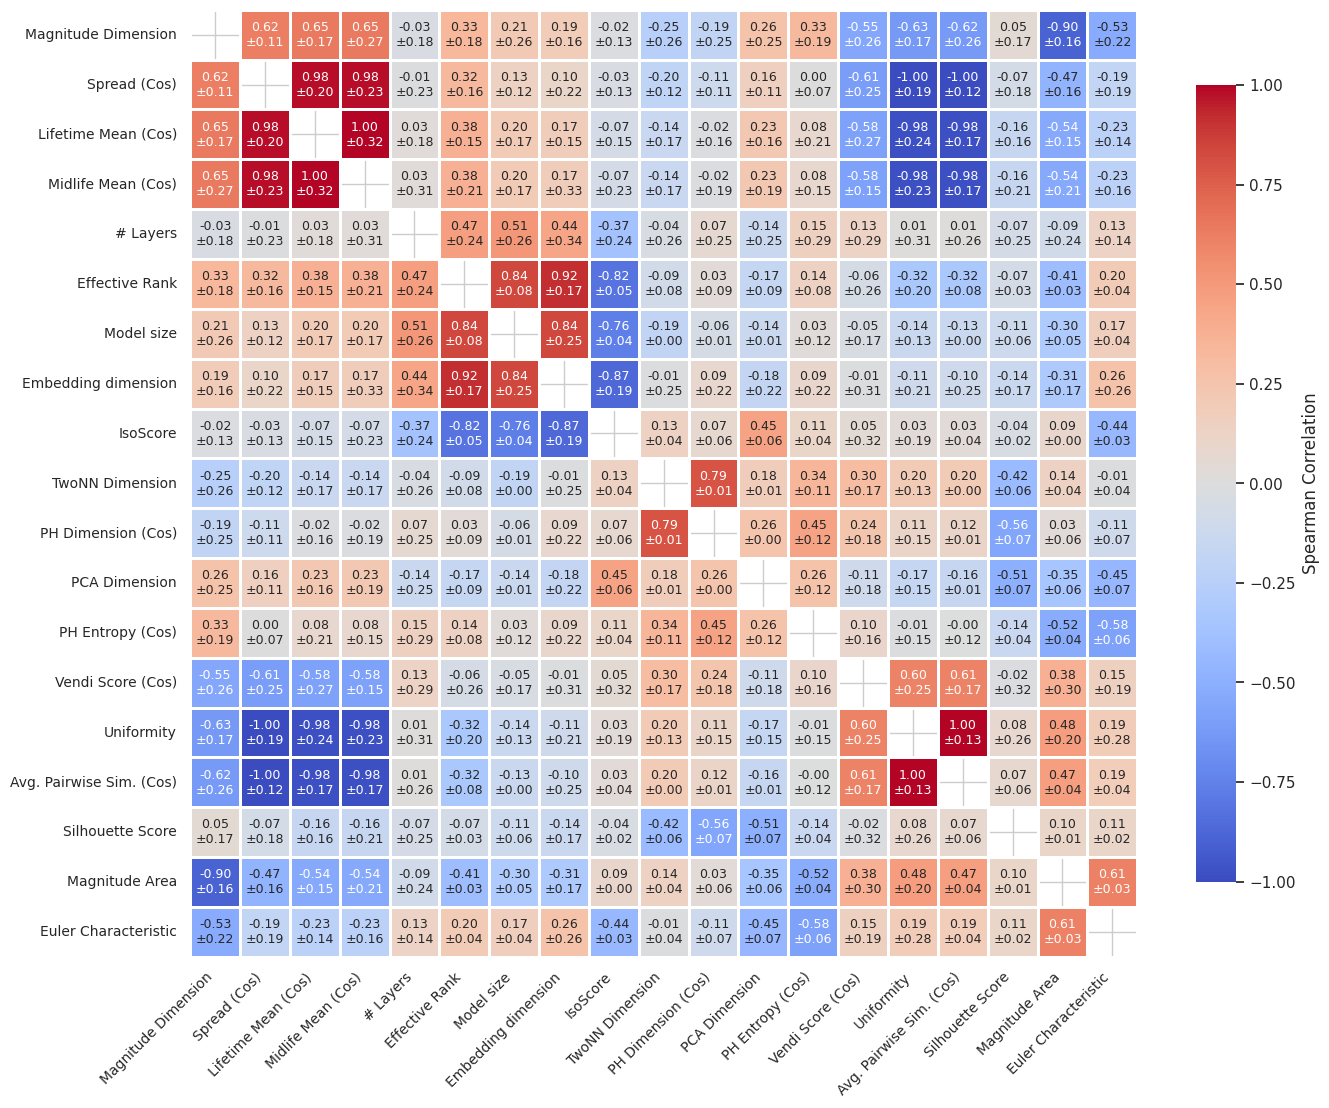

In [4]:
from config.metrics import SIGNATURE_COLUMNS, NAME_MAPPING
from utils.plotting import correlation_matrix_datasets

all_columns = SIGNATURE_COLUMNS + ["model_size", "embedding_dimension", "layers"]
correlation_matrix_datasets(df, all_columns, "coolwarm", figsize=(14, 14), 
                            apply_clustering=True, name_mapping=NAME_MAPPING,
                            save_name="figures/correlation_matrix.pdf")

### Metric patterns

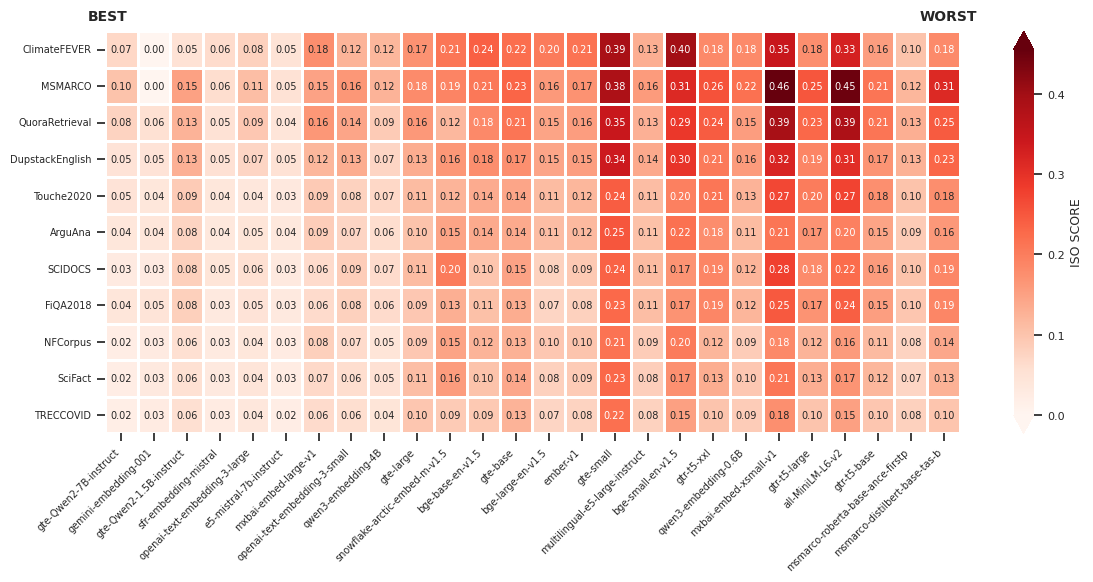

In [5]:
from utils.plotting import plot_gradient_heatmap

df_subset = df[(df["seed"] == 2025)]

plot_gradient_heatmap(df_subset, heat="iso_score", 
                      model_sorting="recall_at_100_normalized", 
                      save_name="figures/heatmap_iso_score.pdf")


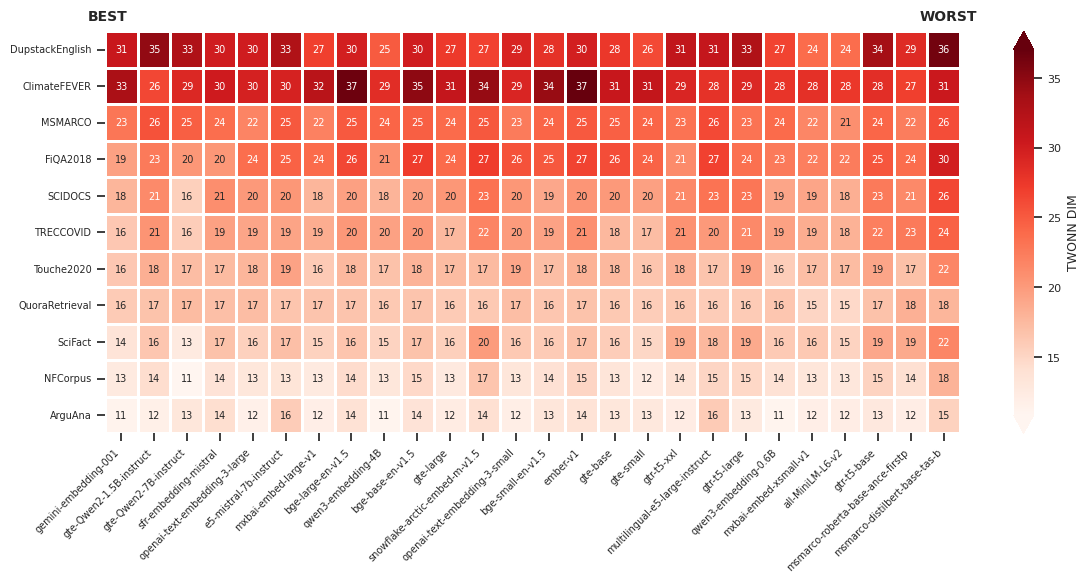

In [6]:
plot_gradient_heatmap(df_subset, heat="twonn_dim", 
                      model_sorting="main_score_normalized", 
                      save_name="figures/heatmap_twonn.pdf") # also silhouette, mag_area

### PCA analysis

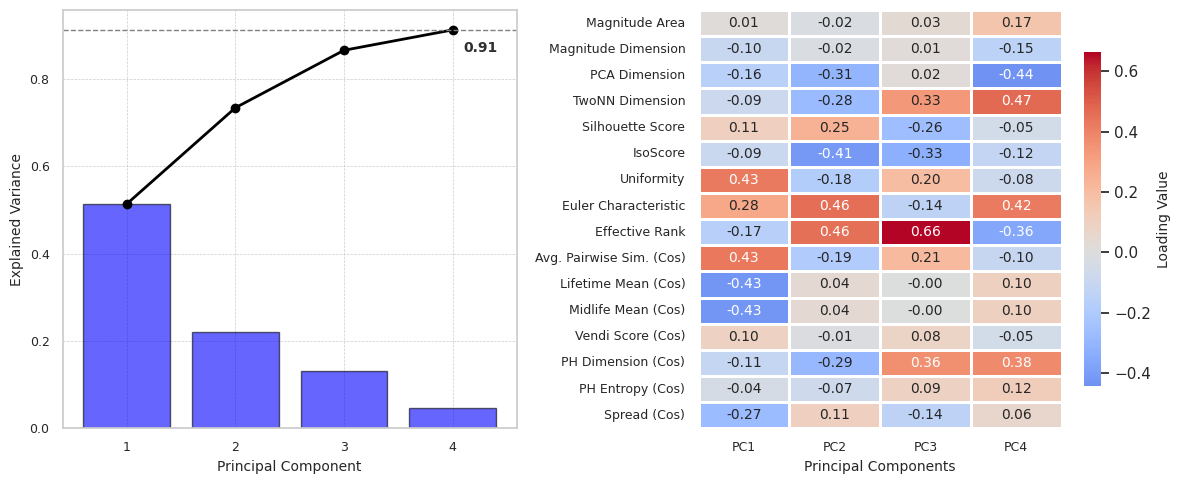

In [7]:
from utils.plotting import plot_pca_loadings
from config.metrics import NAME_MAPPING

loadings_df = plot_pca_loadings(df, SIGNATURE_COLUMNS, components=4, 
                                normalize_all=True, normalize_method="max", 
                                name_mapping=NAME_MAPPING, save_name="figures/pca_loadings.pdf")

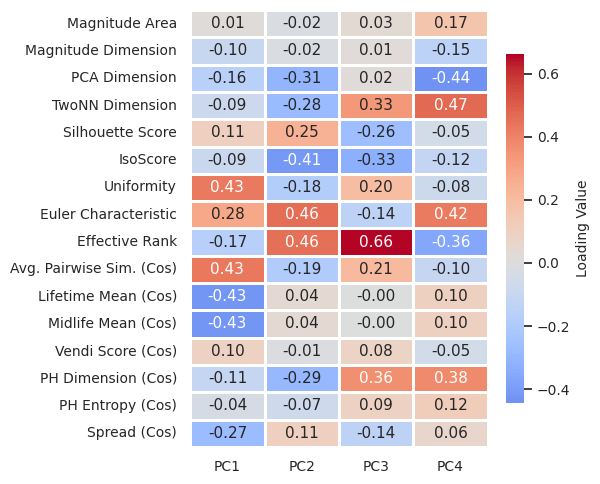

In [8]:
from utils.plotting import plot_pca_loadings2
from config.metrics import NAME_MAPPING
import matplotlib.pyplot as plt

loadings_df = plot_pca_loadings2(df, SIGNATURE_COLUMNS, components=4, 
                                normalize_all=True, normalize_method="max", 
                                name_mapping=NAME_MAPPING, save_name="figures/pca_loadings2.pdf")

Visualize PCA signatures on a specific dataset

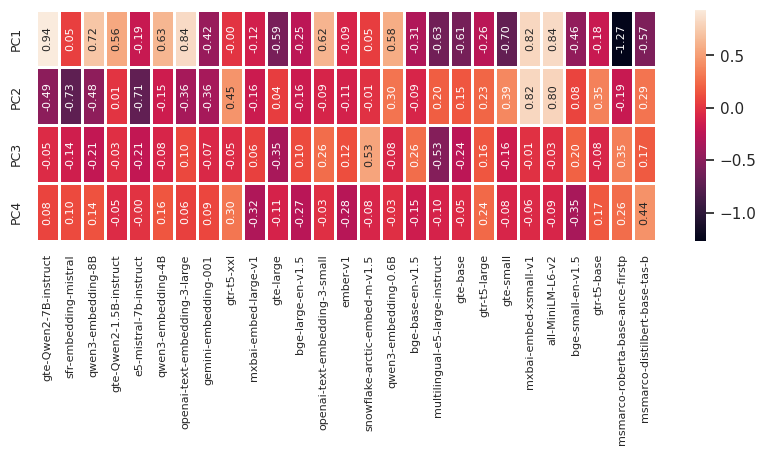

In [11]:
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt
import seaborn as sns

dataset_select = "FiQA2018"
subset = df[(df["dataset"] == dataset_select) 
            & (df["seed"] == 123)].sort_values("recall_at_100", ascending=False)
scaled = subset[SIGNATURE_COLUMNS] / abs(subset[SIGNATURE_COLUMNS]).max()


pca = PCA(n_components=4)
x = pca.fit_transform(scaled) 

# show loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings_df = pd.DataFrame(loadings, columns=[f"PC{i+1}" for i in range(loadings.shape[1])], index=SIGNATURE_COLUMNS)
loadings_df = loadings_df.sort_values("PC1", ascending=False)

# Plot
plt.figure(figsize=(10, 3))
sns.heatmap(x.transpose(), linewidths=0.8, linecolor='white', annot=True, 
            annot_kws={"size": 8, "va": "center",  "rotation": 90}, 
            fmt=".2f", xticklabels=subset.model_name_short, yticklabels=[f"PC{i+1}" for i in range(4)])
plt.xticks(rotation=90, fontsize=8)
plt.yticks(fontsize=9)
plt.show()

### Watermarking


In [24]:
from utils.analysis import signature_predict_cv

all_results = []
target = 'model'
exclude_prop = False
group = "dataset"
show_plot = False

# Remove proprietary models for this analysis
if exclude_prop:
    df_analysis = df[~df.model.isin(["apollo/openai-text-embedding-3-large", 
                                    "apollo/openai-text-embedding-3-small",
                                    "google/gemini-embedding-001"])]
else:
    df_analysis = df.copy()

for embedding_dim in df_analysis["embedding_dimension"].unique().tolist() + ["all"]:
    if embedding_dim != "all":
        subset = df_analysis[(df_analysis["embedding_dimension"] == embedding_dim)]
    else:
        subset = df_analysis

    if subset.model.nunique() < 3:
        print(f"Skipping embedding dimension {embedding_dim} with only {subset.model.nunique()} models")
        continue
    print("Embedding dimension:", embedding_dim)
    preds, results = signature_predict_cv(subset, SIGNATURE_COLUMNS, target, 
                                groups=subset[group], hue="model_name_short", normalize_axis="all",
                                model_type="classification", figsize=(10, 7), n_splits=3, show_plot=show_plot,
                                apply_clustering=True, use_pca=False, normalize_method="max")
    results["embedding_dimension"] = embedding_dim
    results["samples"] = subset.shape[0]
    results["classes"] = subset[target].nunique()
    class_counts = subset[target].value_counts()
    results["class_counts"] = "|".join(class_counts.astype(str).tolist())
    all_results.append(results)

# Show results as table
summary_df = pd.concat(all_results).groupby("embedding_dimension")[["signature_balanced_accuracy", "signature_mcc", "samples", "classes"]].agg(['mean', 'std']).reset_index()
summary_df["random_baseline"] = 1 / summary_df[("classes", "mean")]
summary_df["class_counts"] = pd.concat(all_results).groupby("embedding_dimension")["class_counts"].first().reset_index(drop=True)
summary_df["most_frequent_baseline"] = summary_df["class_counts"].apply(lambda x: 
                                                max([int(i) for i in x.split("|")]) / sum([int(i) 
                                                                        for i in x.split("|")]) 
                                                if len(x.split("|")) > 1 else 1)
summary_df.iloc[::-1]

Skipping embedding dimension 1536 with only 2 models
Skipping embedding dimension 3584 with only 1 models
Embedding dimension: 768
Train Balanced Accuracy: 0.9821
Train Balanced Accuracy: 0.9405
Train Balanced Accuracy: 0.9375
Embedding dimension: 1024
Train Balanced Accuracy: 1.0000
Train Balanced Accuracy: 1.0000
Train Balanced Accuracy: 1.0000
Embedding dimension: 384
Train Balanced Accuracy: 1.0000
Train Balanced Accuracy: 1.0000
Train Balanced Accuracy: 1.0000
Skipping embedding dimension 2560 with only 1 models
Embedding dimension: 4096
Train Balanced Accuracy: 1.0000
Train Balanced Accuracy: 1.0000
Train Balanced Accuracy: 1.0000
Skipping embedding dimension 3072 with only 2 models
Skipping embedding dimension 512 with only 1 models
Embedding dimension: all
Train Balanced Accuracy: 0.8889
Train Balanced Accuracy: 0.9259
Train Balanced Accuracy: 0.9030


embedding_dimension signature_balanced_accuracy           signature_mcc   
                                             mean       std          mean   
4                 all                    0.661866  0.028387      0.654592  \
3                4096                    0.888889  0.100154      0.826471   
2                1024                    0.677778  0.134715      0.609246   
1                 768                    0.732639  0.121627      0.707200   
0                 384                    0.756944  0.012028      0.691902   

            samples      classes      random_baseline   
        std    mean  std    mean  std                   
4  0.025079   882.0  0.0    27.0  0.0        0.037037  \
3  0.146854    90.0  0.0     3.0  0.0        0.333333   
2  0.169791   165.0  0.0     5.0  0.0        0.200000   
1  0.137629   264.0  0.0     8.0  0.0        0.125000   
0  0.009763   132.0  0.0     4.0  0.0        0.250000   

                                        class_counts most_frequent_baseline  
                                                                             
4  33|33|33|33|33|33|33|33|33|33|33|33|33|33|33|3...               0.037415  
3                                           33|33|24               0.366667  
2                                     33|33|33|33|33               0.200000  
1                            33|33|33|33|33|33|33|33               0.125000  
0                                        33|33|33|33               0.250000

### Topological similarity

Number of groups: 11


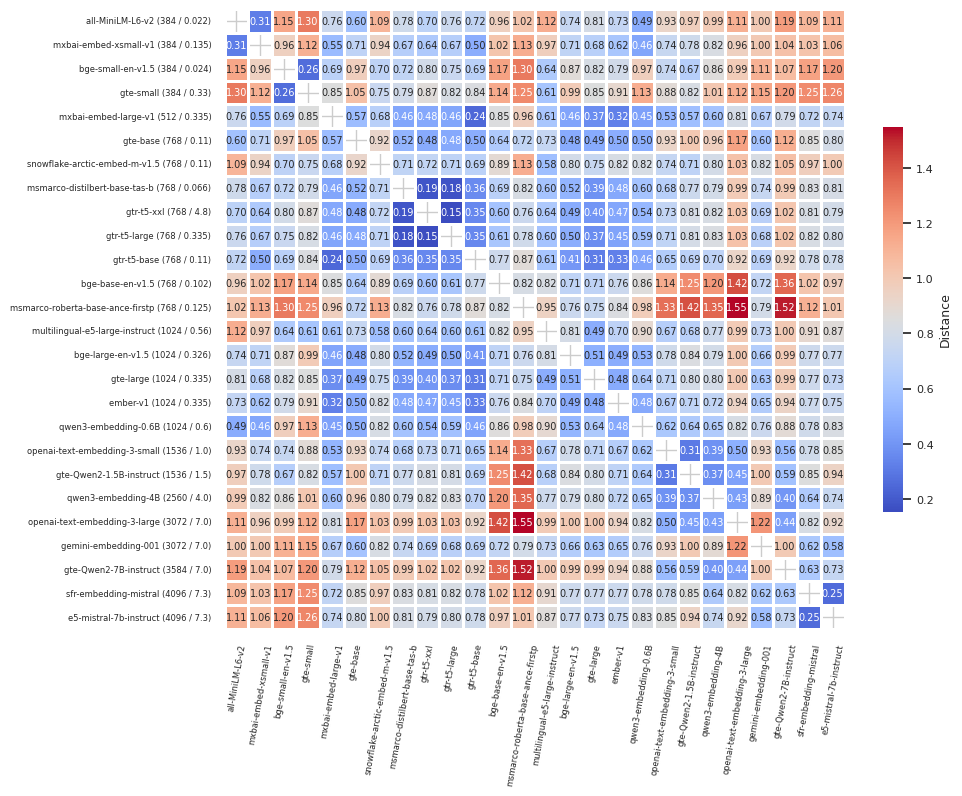

In [25]:
from utils.analysis import compute_pairwise_distances_grouped
from utils.plotting import plot_and_aggregate_dist_matrices

df_subset = df[(df["seed"] == 2025)]
matrices, filtered_df, last_sorted_group = compute_pairwise_distances_grouped(df_subset, 
                                                                              SIGNATURE_COLUMNS, 
                                                                              group="dataset", 
                                                                              sort_by="embedding_dimension", 
                                                                              normalize_axis="all",
                                                                              normalize_method="max",
                                                                              use_pca=False,
                                                                              complete_models_only=True)
plot_and_aggregate_dist_matrices(matrices, filtered_df, last_sorted_group, agg_func=np.nanmean, ticks_key="model_name_short", figsize=(10, 10), colors=["#1f77b4", "#ffffff", "#d62728"])

Distances across datasets

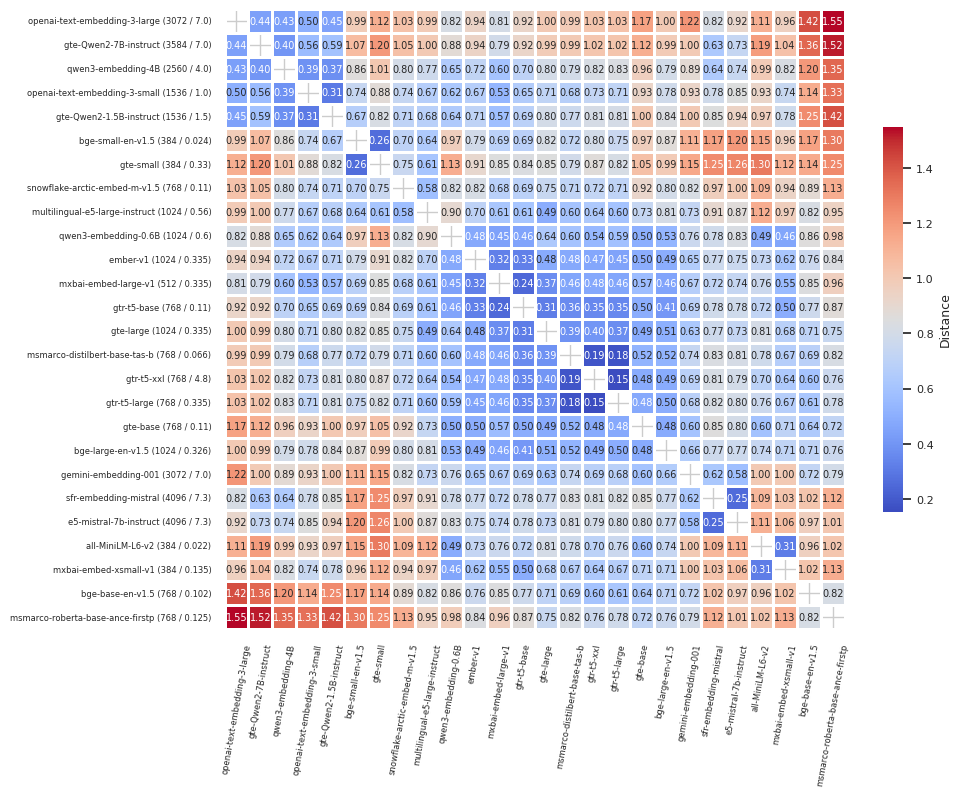

In [26]:
plot_and_aggregate_dist_matrices(matrices, filtered_df, last_sorted_group, agg_func=np.nanmean,
                                 ticks_key="model_name_short", figsize=(10, 10), colors=["#1f77b4", "#ffffff", "#d62728"], apply_clustering=True, save_name="figures/pairwise_distance_matrix_clustered.pdf")

Values for small 105
Values for large 28
Values for medium 6


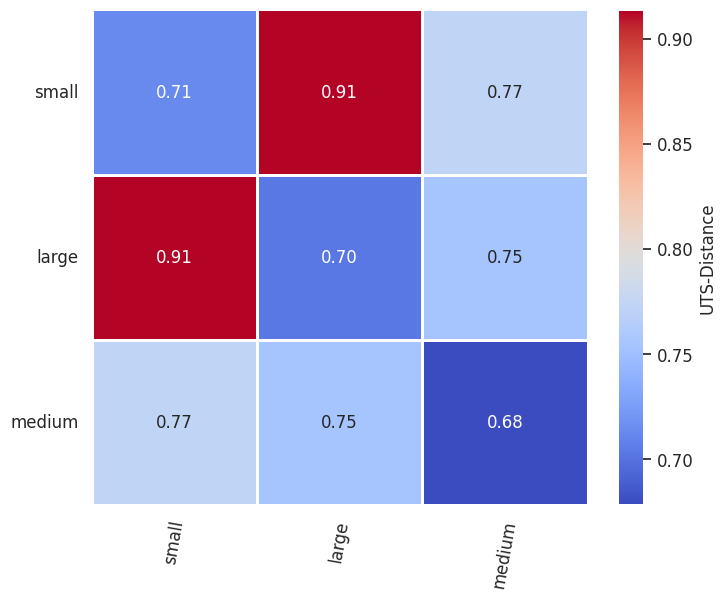

In [66]:
from utils.plotting import plot_clustered_family_dist_heatmap
from utils.analysis import compute_intra_distances

prop = "size"
dist_df, model_family_matrix = compute_intra_distances(matrices, 
                                                        last_sorted_group, 
                                                        prop=prop,
                                                        min_samples=1)
model_family_matrix = pd.DataFrame(model_family_matrix)
drop_idx = (~(model_family_matrix == 0).all()).tolist()
zero_columns = model_family_matrix.columns[(model_family_matrix == 0).all()]


model_family_matrix_filtered = model_family_matrix.drop(columns=zero_columns)
model_family_matrix_filtered = model_family_matrix_filtered.loc[drop_idx]
model_family_matrix_filtered = model_family_matrix_filtered.reset_index(drop=True)

plot_clustered_family_dist_heatmap(model_family_matrix_filtered, 
                                   save_name=f"figures/{prop}_distance_matrix.pdf",
                                   cluster=True,
                                   defined_order=["small", "medium", "large"])

Values for MiniLM 3
Values for BGE 3
Values for GTE 3
Values for T5 3
Skipping Arctic due to insufficient data.
Skipping ANCE due to insufficient data.
Skipping TAS due to insufficient data.
Values for Qwen 10
Values for E5 3
Skipping Ember due to insufficient data.
Values for OpenAI 1
Skipping Gemini due to insufficient data.


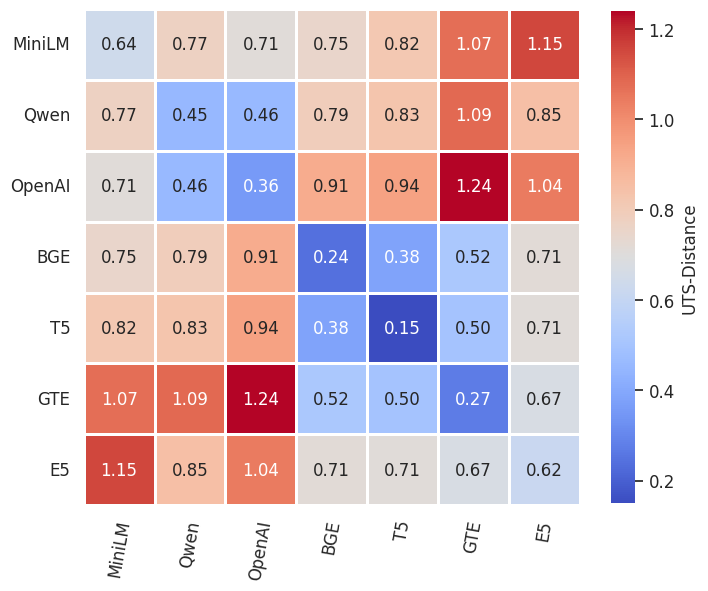

In [67]:
from utils.plotting import plot_clustered_family_dist_heatmap
from utils.analysis import compute_intra_distances

prop = "model_family"
dist_df, model_family_matrix = compute_intra_distances(matrices, 
                                                        last_sorted_group, 
                                                        prop=prop,
                                                        min_samples=1)
model_family_matrix = pd.DataFrame(model_family_matrix)
drop_idx = (~(model_family_matrix == 0).all()).tolist()
zero_columns = model_family_matrix.columns[(model_family_matrix == 0).all()]


model_family_matrix_filtered = model_family_matrix.drop(columns=zero_columns)
model_family_matrix_filtered = model_family_matrix_filtered.loc[drop_idx]
model_family_matrix_filtered = model_family_matrix_filtered.reset_index(drop=True)

plot_clustered_family_dist_heatmap(model_family_matrix_filtered, 
                                   save_name=f"figures/{prop}_distance_matrix.pdf",
                                   cluster=True)

### Largest differences in signature vectors of different model families

In [29]:
import matplotlib.pyplot as plt
from utils.analysis import compute_pairwise_distances_grouped

df_subset = df[df["seed"] == 2025]
matrices, filtered_df, last_sorted_group = compute_pairwise_distances_grouped(df_subset, 
                                                                              SIGNATURE_COLUMNS, 
                                                                              group="model_family", 
                                                                              sort_by="embedding_dimension", 
                                                                              normalize_axis="all",
                                                                              normalize_method="max",
                                                                              use_pca=False,
                                                                              complete_models_only=True,
                                                                              return_full_distances=True)

values_per_family = {}
for i, family in enumerate(filtered_df.model_family.unique()):
    family_matrix = matrices[i]
    per_feature_mean_dist = family_matrix.mean(axis=0).mean(axis=0)

    values_per_family[family] = {"feature": [], "mean_distance": []}
    for val, feat in zip(per_feature_mean_dist, SIGNATURE_COLUMNS):
        values_per_family[family]["feature"].append(feat)
        values_per_family[family]["mean_distance"].append(val)

dfs = []
for k in values_per_family.keys():
    df_vals = pd.DataFrame().from_dict(values_per_family[k])
    df_vals["family"] = k
    dfs.append(df_vals)
dfs = pd.concat(dfs)

Number of groups: 12


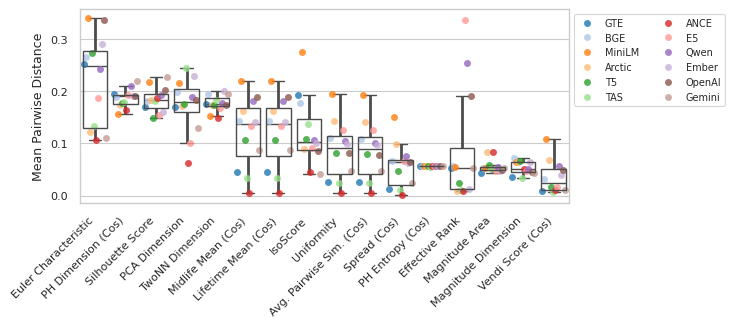

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from config.metrics import NAME_MAPPING

# Set up the plot style and palette
bi = sns.color_palette(["#00E47C", 
                        "#ffd03d",
                        "#6ad2e2",
                        "#ee6541",
                        "#928bde",
                        "#86251b",
                        "#076d7e",
                        "#e18600"])
colors = ["#08312A", "#00E47C"]
palette = sns.blend_palette(colors, n_colors=10, as_cmap=False)
sns.set_theme(style="whitegrid", context="paper", font_scale=1.4)
plt.figure(figsize=(6, 4))

dfs["metric"] = dfs["feature"].map(NAME_MAPPING)
median_distances = dfs.groupby("metric")["mean_distance"].median().sort_values(ascending=False).index

sns.boxplot(
    data=dfs,
    x="metric",
    y="mean_distance",
    dodge=True,
    showcaps=True,
    boxprops={'facecolor': 'none', 'zorder': 10},
    showfliers=False,
    whiskerprops={'linewidth': 2},
    linewidth=1,
    order=median_distances
)

sns.stripplot(
    data=dfs,
    x="metric",
    y="mean_distance",
    hue="family",
    jitter=0.05,
    dodge=True,
    palette="tab20",
    #edgecolor="black",
    #linewidth=0.5,
    alpha=0.8,
    order=median_distances
)
# set x axis ticks size smaller
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('', fontsize=9)
plt.ylabel('Mean Pairwise Distance', fontsize=9)
plt.tight_layout()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=True, fontsize=7, ncols=2)
plt.savefig("figures/mean_discriminative_features_family.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

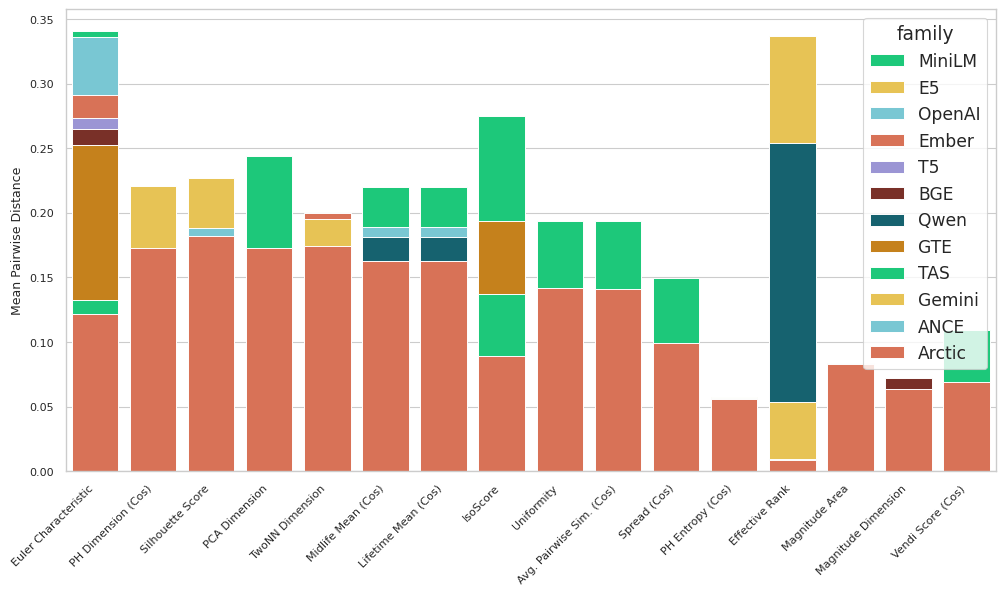

In [31]:
dfs = dfs.sort_values("mean_distance", ascending=False)
median_distances = dfs.groupby("metric")["mean_distance"].median().sort_values(ascending=False).index

sns.barplot(dfs, 
            x="metric", 
            y="mean_distance", 
            errorbar="sd",
            dodge=False, 
            hue="family",        
            palette=bi,      
            edgecolor=None,
            linewidth=0.7,
            errwidth=1,
            alpha=1, 
            order=median_distances)
# Rotate labels
plt.xlabel('', fontsize=9)
plt.yticks(fontsize=8)
plt.ylabel('Mean Pairwise Distance', fontsize=9)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.show()

### UMAP overview

Processing:  gte-Qwen2-1.5B-instruct
Loading embeddings for model:  cache_Alibaba-NLP_gte-Qwen2-1.5B-instruct  and task:  ArguAna
Looking for files at:  results/Alibaba-NLP/gte-Qwen2-1.5B-instruct/Alibaba-NLP__gte-Qwen2-1.5B-instruct
[('results/Alibaba-NLP/gte-Qwen2-1.5B-instruct/Alibaba-NLP__gte-Qwen2-1.5B-instruct', ['c6c1b92f4a3e1b92b326ad29dd3c8433457df8dd'], []), ('results/Alibaba-NLP/gte-Qwen2-1.5B-instruct/Alibaba-NLP__gte-Qwen2-1.5B-instruct/c6c1b92f4a3e1b92b326ad29dd3c8433457df8dd', [], ['ArguAna.json', 'CQADupstackEnglishRetrieval.json', 'ClimateFEVER.json', 'FiQA2018.json', 'MSMARCO.json', 'NFCorpus.json', 'QuoraRetrieval.json', 'SCIDOCS.json', 'SciFact.json', 'TRECCOVID.json', 'Touche2020.json', 'model_meta.json'])]


Processing:  bge-large-en-v1.5
Loading embeddings for model:  cache_BAAI_bge-large-en-v1.5  and task:  ArguAna
Looking for files at:  results/BAAI/bge-large-en-v1.5/BAAI__bge-large-en-v1.5
[('results/BAAI/bge-large-en-v1.5/BAAI__bge-large-en-v1.5', ['d4aa6901d3a41ba39fb536a557fa166f842b0e09'], []), ('results/BAAI/bge-large-en-v1.5/BAAI__bge-large-en-v1.5/d4aa6901d3a41ba39fb536a557fa166f842b0e09', [], ['ArguAna.json', 'CQADupstackEnglishRetrieval.json', 'ClimateFEVER.json', 'FiQA2018.json', 'MSMARCO.json', 'NFCorpus.json', 'NFCorpusold.json', 'NanoDBPediaRetrieval.json', 'NanoFEVERRetrieval.json', 'NanoFiQA2018Retrieval.json', 'NanoMSMARCORetrieval.json', 'NanoQuoraRetrieval.json', 'QuoraRetrieval.json', 'SCIDOCS.json', 'SciFact.json', 'TRECCOVID.json', 'Touche2020.json', 'model_meta.json'])]
Processing:  mxbai-embed-large-v1
Loading embeddings for model:  cache_mixedbread-ai_mxbai-embed-large-v1  and task:  ArguAna
Looking for files at:  results/mixedbread-ai/mxbai-embed-large-v1/mixed

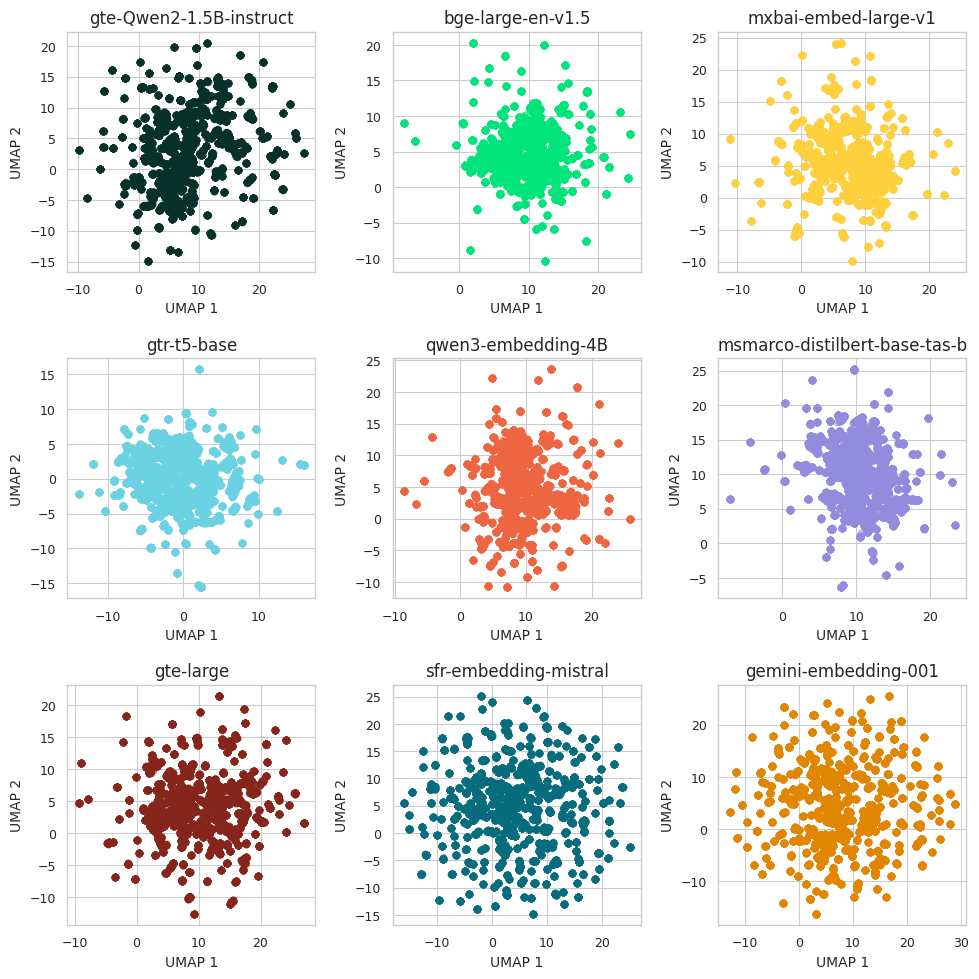

In [73]:
import matplotlib.pyplot as plt
import umap
from utils.general import load_embeddings, process_embeddings, separate_query_vectors


colors = ["#08312A", "#00E47C", "#ffd03d", "#6ad2e2",
          "#ee6541", "#928bde", "#86251b", "#076d7e", "#e18600"]
dataset = "ArguAna"
models = [
    "Alibaba-NLP/gte-Qwen2-1.5B-instruct",
    "BAAI/bge-large-en-v1.5",
    "mixedbread-ai/mxbai-embed-large-v1",
    "sentence-transformers/gtr-t5-base",
    "Qwen/Qwen3-Embedding-4B",
    "sentence-transformers/msmarco-distilbert-base-tas-b",
    "thenlper/gte-large",
    "Salesforce/SFR-Embedding-Mistral",
    "google/gemini-embedding-001"
]

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, model in enumerate(models):
    short_name = df[df.model == model].iloc[0].model_name_short
    print("Processing: ", short_name)
    cached_name = f"cache_{model}".replace("/", "_")
    data, results = load_embeddings(cached_name, dataset)
    vectors = process_embeddings(data)
    query_vectors, collection_vectors = separate_query_vectors(data, vectors, model, dataset)

    umap_model = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine')
    umap_results = umap_model.fit_transform(collection_vectors)

    axes[i].scatter(umap_results[:, 0], umap_results[:, 1], alpha=0.5, color=colors[i % len(colors)])
    axes[i].set_title(short_name, fontsize=12)
    axes[i].set_xlabel('UMAP 1', fontsize=10)
    axes[i].set_ylabel('UMAP 2', fontsize=10)
    axes[i].tick_params(axis='both', labelsize=9) 

# Adjust layout
plt.tight_layout()
plt.savefig("figures/grid_umap.png", dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Signature distributions

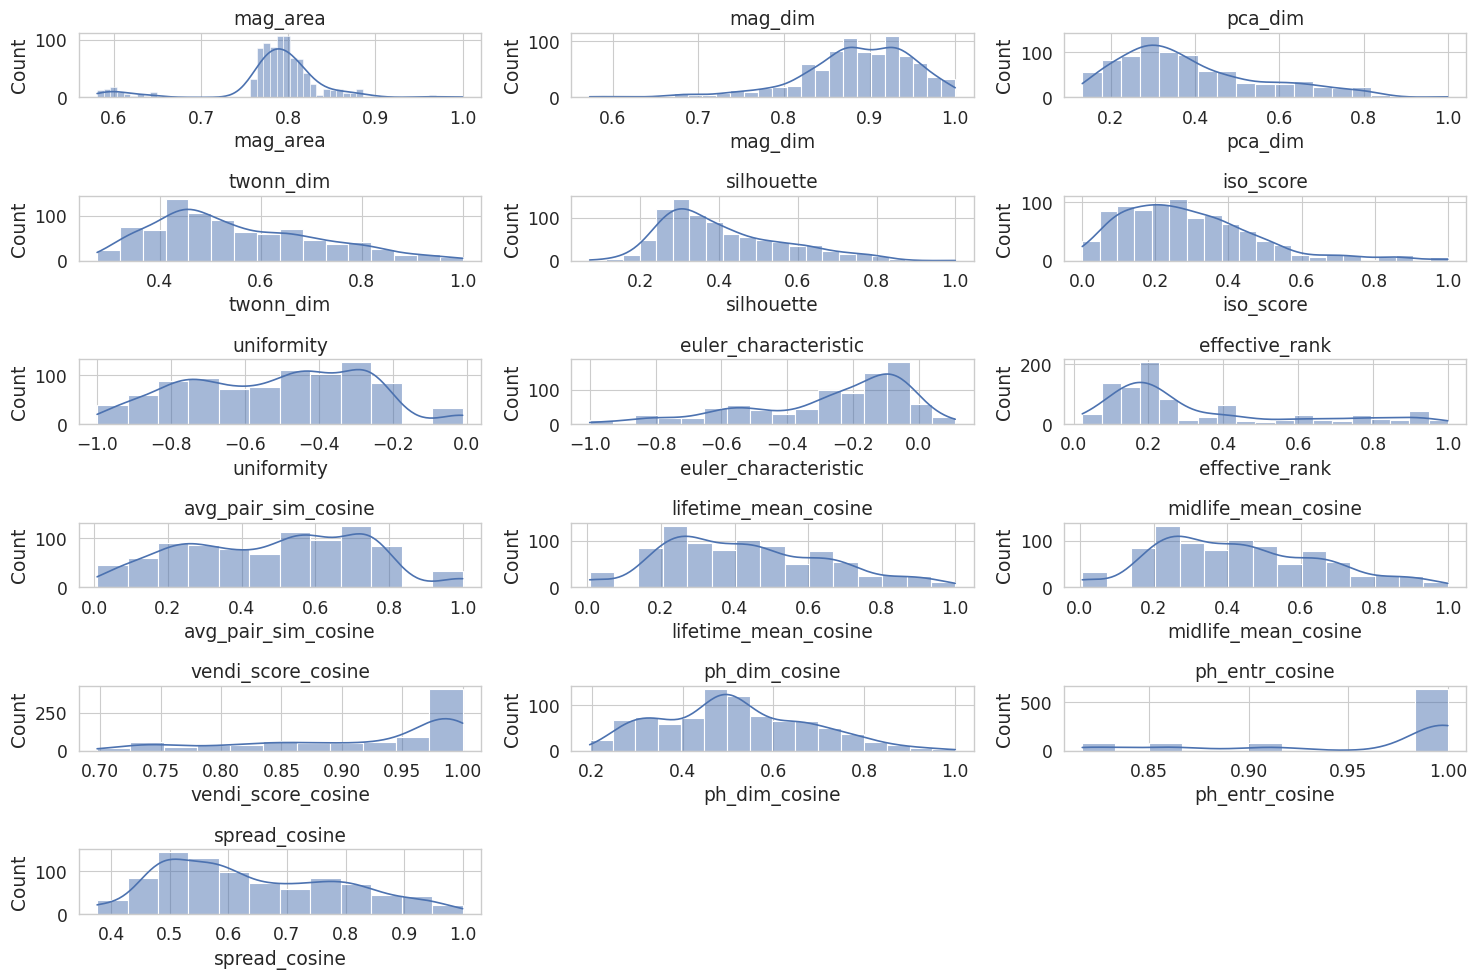

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

df[SIGNATURE_COLUMNS] = df[SIGNATURE_COLUMNS] / np.max(abs(df[SIGNATURE_COLUMNS]), axis=0)

plt.figure(figsize=(15, 10))
num_columns = len(SIGNATURE_COLUMNS)
rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calculate the number of rows needed
for i, column in enumerate(SIGNATURE_COLUMNS):
    plt.subplot(rows, 3, i + 1)  # Adjust the number of rows and columns as needed
    sns.histplot(df[column], kde=True)
    plt.title(column)
plt.tight_layout()
plt.show()
